In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gradient-descent/AI-InvestorFinalProjectPart2.docx
/kaggle/input/gradient-descent/sample_submission.csv
/kaggle/input/gradient-descent/bureau_balance.csv
/kaggle/input/gradient-descent/POS_CASH_balance.csv
/kaggle/input/gradient-descent/application_train.csv
/kaggle/input/gradient-descent/HomeCredit_columns_description.csv
/kaggle/input/gradient-descent/AI-InvestorFinalProject.docx
/kaggle/input/gradient-descent/application_test.csv
/kaggle/input/gradient-descent/previous_application.csv
/kaggle/input/gradient-descent/constituents_csv.csv
/kaggle/input/gradient-descent/credit_card_balance.csv
/kaggle/input/gradient-descent/installments_payments.csv
/kaggle/input/gradient-descent/bureau.csv


In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/kaggle/input/gradient-descent/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/kaggle/input/gradient-descent/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [4]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score
#https://catboost.ai/en/docs/concepts/python-reference_utils_get_roc_curve
#https://www.kaggle.com/code/romantihiy/catboost-0-96-auc/notebook

Train samples: 307511, test samples: 48744
Starting catBoost. Train shape: (307507, 248), test shape: (48744, 248)
0:	learn: 0.5893173	test: 0.5900537	best: 0.5900537 (0)	total: 100ms	remaining: 1m 39s
1:	learn: 0.5175237	test: 0.5185914	best: 0.5185914 (1)	total: 144ms	remaining: 1m 11s
2:	learn: 0.4622063	test: 0.4636805	best: 0.4636805 (2)	total: 185ms	remaining: 1m 1s
3:	learn: 0.4203195	test: 0.4220307	best: 0.4220307 (3)	total: 225ms	remaining: 56.1s
4:	learn: 0.3848971	test: 0.3869678	best: 0.3869678 (4)	total: 274ms	remaining: 54.5s
5:	learn: 0.3591804	test: 0.3615748	best: 0.3615748 (5)	total: 331ms	remaining: 54.8s
6:	learn: 0.3405627	test: 0.3432013	best: 0.3432013 (6)	total: 375ms	remaining: 53.2s
7:	learn: 0.3231618	test: 0.3259169	best: 0.3259169 (7)	total: 433ms	remaining: 53.7s
8:	learn: 0.3110217	test: 0.3138969	best: 0.3138969 (8)	total: 480ms	remaining: 52.9s
9:	learn: 0.3003381	test: 0.3034158	best: 0.3034158 (9)	total: 537ms	remaining: 53.1s
10:	learn: 0.2916655	te

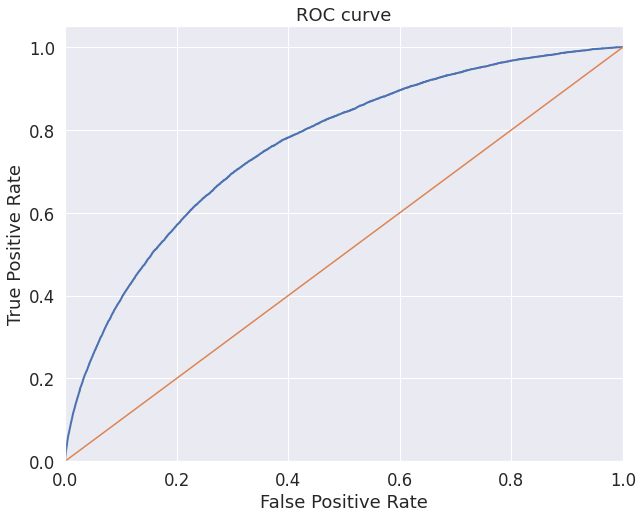

['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_base_calc_leaf_indexes', '_base_drop_unused_features', '_base_eval_metrics', '_base_predict', '_base_shrink', '_base_virtual_ensembles_predict', '_calc_fstr', '_calc_leaf_indexes', '_calc_ostr', '_check_is_compatible_loss', '_convert_to_asymmetric_representation', '_deserialize_model', '_estimator_type', '_eval_metrics', '_fit', '_get_borders', '_get_cat_feature_indices', '_get_embedding_feature_indices', '_get_float_feature_indices', '_get_nan_treatments', '_get_params', '_get_tags', '_get_text_feature_indices', '_get_tree_leaf_values', '_get_tree_node_to_leaf', '_get_tree_splits', '_g

In [5]:

# Catboost with KFold or Stratified KFold

def kfold_catboost(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting catBoost. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        """
        catClf = CatBoostClassifier(
            iterations=15, 
            learning_rate=0.5, 
            loss_function='CrossEntropy'
        )
        """
        catClf = CatBoostClassifier()
        grid = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10],
                'l2_leaf_reg': [1, 3, 5, 7, 9]}
        catClf.randomized_search(grid, X=train_x, y=train_y)
        
        catClf.fit(train_x, train_y)
        predictions = catClf.predict(valid_x)
        predictionsTrain = catClf.predict(train_x)
        print("accuracy of the catboost: ",accuracy_score(valid_y,predictions))
        print('Test ROC AUC =', roc_auc_score(valid_y, predictions))
        print('Train ROC AUC =', roc_auc_score(train_y, predictionsTrain))
        
       
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(valid_y, catClf.predict_proba(valid_x)[:,1], pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    print(dir(catClf))
        
    return catClf

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    """
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    """
    with timer("Run LightGBM with kfold"):
        model = kfold_catboost(df, num_folds= 2, stratified= False, debug= debug)

#if __name__ == "__main__":
submission_file_name = "submission_kernel02.csv"
with timer("Full model run"):
    """
    [LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
    [200]	training's auc: 0.774705	training's binary_logloss: 0.241492	valid_1's auc: 0.76061	valid_1's binary_logloss: 0.250624
    [400]	training's auc: 0.793039	training's binary_logloss: 0.235213	valid_1's auc: 0.76696	valid_1's binary_logloss: 0.248285
    [600]	training's auc: 0.805942	training's binary_logloss: 0.231025	valid_1's auc: 0.768789	valid_1's binary_logloss: 0.247595
    [800]	training's auc: 0.816932	training's binary_logloss: 0.227412	valid_1's auc: 0.769609	valid_1's binary_logloss: 0.247258
    [1000]	training's auc: 0.826627	training's binary_logloss: 0.224124	valid_1's auc: 0.769926	valid_1's binary_logloss: 0.247152
    Fold  1 AUC : 0.770105
    "
    [LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
    [200]	training's auc: 0.774547	training's binary_logloss: 0.24208	valid_1's auc: 0.761697	valid_1's binary_logloss: 0.245617
    [400]	training's auc: 0.792338	training's binary_logloss: 0.235938	valid_1's auc: 0.768772	valid_1's binary_logloss: 0.243026

    ##################################################################################################################################
    
    Train ROC AUC = 0.5047895137660634
    0:	learn: 0.3479255	total: 109ms	remaining: 1.52s
    1:	learn: 0.2780125	total: 226ms	remaining: 1.47s
    2:	learn: 0.2642669	total: 351ms	remaining: 1.4s
    3:	learn: 0.2574169	total: 473ms	remaining: 1.3s
    4:	learn: 0.2538224	total: 603ms	remaining: 1.21s
    5:	learn: 0.2521725	total: 738ms	remaining: 1.11s
    6:	learn: 0.2511846	total: 877ms	remaining: 1s
    7:	learn: 0.2501377	total: 1.02s	remaining: 889ms
    8:	learn: 0.2495308	total: 1.13s	remaining: 753ms
    9:	learn: 0.2490390	total: 1.29s	remaining: 645ms
    10:	learn: 0.2485886	total: 1.42s	remaining: 518ms
    11:	learn: 0.2482280	total: 1.56s	remaining: 389ms
    12:	learn: 0.2479119	total: 1.68s	remaining: 259ms
    13:	learn: 0.2473593	total: 1.82s	remaining: 130ms
    14:	learn: 0.2470713	total: 1.94s	remaining: 0us
    accuracy of the catboost:  0.9209756097560976
    Test ROC AUC = 0.5091560327693521
    Train ROC AUC = 0.5077355912850905
    """
    main()